In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-data-aggregated-progress/train_data_aggregated_progress.csv
/kaggle/input/train-data-sample/train_data_sample.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from tensorflow import keras
import shap
import time
import pickle
import plotly.graph_objects as go
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [3]:
train_data_sample = pd.read_csv('/kaggle/input/train-data-sample/train_data_sample.csv')
train_data_sample.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2017-03-31,0.567442,0.268476,0.070311,0.812053,0.004228,0.407420,0.007732,0.010927,...,NaN,NaN,0.003295,0.004272,0.000242,NaN,0.006266,0.001873,0.007589,0
1,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2017-04-21,0.568356,0.001642,0.083223,0.819809,0.006591,0.228103,0.005514,0.002281,...,NaN,NaN,0.007134,0.009733,0.006759,NaN,0.009192,0.002681,0.009768,0
2,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2017-05-29,0.581232,0.206867,0.279991,1.004374,0.001605,0.149216,0.008668,0.008219,...,NaN,NaN,0.004132,0.003133,0.007118,NaN,0.003069,0.000492,0.004728,0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2017-06-24,0.581547,0.093481,0.172628,1.003796,0.009453,0.153152,0.003694,0.002178,...,NaN,NaN,0.009114,0.005683,0.006940,NaN,0.009421,0.007502,0.007468,0
4,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,2017-07-16,0.598278,0.000660,0.045268,1.007780,0.008866,0.162771,0.004137,0.007301,...,NaN,NaN,0.006197,0.000461,0.003700,NaN,0.006243,0.007881,0.000029,0


In [4]:
train_data_sample.describe()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
count,1.095696e+06,1.105022e+06,1.105022e+06,1.104655e+06,1.105022e+06,902311.000000,1.104655e+06,1.104655e+06,157575.000000,7.743390e+05,...,3.900200e+04,3.900200e+04,1.084614e+06,1.096707e+06,1.084614e+06,189555.000000,1.084614e+06,1.096673e+06,1.084614e+06,1.105022e+06
mean,6.565671e-01,1.523060e-01,1.239716e-01,6.226051e-01,7.884451e-02,0.225242,6.001593e-02,1.323698e-01,0.184053,1.540113e-01,...,1.467523e-02,1.658488e-01,1.797722e-01,2.607664e-02,1.653392e-01,0.391195,1.796032e-01,5.303111e-02,6.272251e-02,2.481145e-01
std,2.446581e-01,2.681733e-01,2.123166e-01,4.011220e-01,2.265828e-01,0.192577,2.036475e-01,2.353398e-01,0.227527,2.136228e-01,...,9.789702e-02,2.667181e-01,3.797834e-01,1.436838e-01,3.490424e-01,0.236541,3.796355e-01,1.836962e-01,1.945238e-01,4.319188e-01
min,-3.961235e-01,2.358775e-08,-7.588799e+00,9.192280e-09,2.600494e-09,-0.491539,6.945091e-09,4.869306e-08,-0.000304,6.194853e-07,...,1.078787e-08,5.890497e-08,2.454762e-08,7.897955e-09,8.690970e-09,-0.014441,7.308187e-09,4.524265e-08,2.811854e-09,0.000000e+00
25%,4.796294e-01,4.525363e-03,8.867937e-03,1.063125e-01,2.893211e-03,0.127398,2.867551e-03,5.227466e-03,0.037088,4.208528e-02,...,2.524371e-03,3.551675e-03,3.028843e-03,2.553406e-03,3.030028e-03,0.200181,3.037131e-03,2.762310e-03,3.030533e-03,0.000000e+00
50%,6.943573e-01,9.046376e-03,3.118152e-02,8.143757e-01,5.779192e-03,0.163986,5.743116e-03,9.775439e-03,0.119965,8.844299e-02,...,5.074339e-03,7.078515e-03,6.057896e-03,5.099335e-03,6.067836e-03,0.382914,6.060695e-03,5.520258e-03,6.065233e-03,0.000000e+00
75%,8.651434e-01,2.360674e-01,1.251556e-01,1.002409e+00,8.662909e-03,0.257392,8.613159e-03,1.536680e-01,0.250022,1.838566e-01,...,7.580778e-03,5.016604e-01,9.090790e-03,7.654209e-03,9.090129e-03,0.559708,9.086867e-03,8.274086e-03,9.094806e-03,0.000000e+00
max,1.010000e+00,5.362538e+00,1.324052e+00,1.010000e+00,3.256284e+00,3.379019,7.510052e+00,1.507130e+00,4.189044,1.011162e+01,...,1.009987e+00,2.509600e+00,1.010000e+00,1.010000e+00,1.281240e+00,1.978865,1.010000e+00,1.343331e+00,3.554169e+00,1.000000e+00


In [5]:
train_data_sample.shape

(1105022, 191)

In [6]:
all_cols  =[col for col in list(train_data_sample.columns) if col not in ['customer_ID','S_2',"target"]]
all_cols

['P_2',
 'D_39',
 'B_1',
 'B_2',
 'R_1',
 'S_3',
 'D_41',
 'B_3',
 'D_42',
 'D_43',
 'D_44',
 'B_4',
 'D_45',
 'B_5',
 'R_2',
 'D_46',
 'D_47',
 'D_48',
 'D_49',
 'B_6',
 'B_7',
 'B_8',
 'D_50',
 'D_51',
 'B_9',
 'R_3',
 'D_52',
 'P_3',
 'B_10',
 'D_53',
 'S_5',
 'B_11',
 'S_6',
 'D_54',
 'R_4',
 'S_7',
 'B_12',
 'S_8',
 'D_55',
 'D_56',
 'B_13',
 'R_5',
 'D_58',
 'S_9',
 'B_14',
 'D_59',
 'D_60',
 'D_61',
 'B_15',
 'S_11',
 'D_62',
 'D_63',
 'D_64',
 'D_65',
 'B_16',
 'B_17',
 'B_18',
 'B_19',
 'D_66',
 'B_20',
 'D_68',
 'S_12',
 'R_6',
 'S_13',
 'B_21',
 'D_69',
 'B_22',
 'D_70',
 'D_71',
 'D_72',
 'S_15',
 'B_23',
 'D_73',
 'P_4',
 'D_74',
 'D_75',
 'D_76',
 'B_24',
 'R_7',
 'D_77',
 'B_25',
 'B_26',
 'D_78',
 'D_79',
 'R_8',
 'R_9',
 'S_16',
 'D_80',
 'R_10',
 'R_11',
 'B_27',
 'D_81',
 'D_82',
 'S_17',
 'R_12',
 'B_28',
 'R_13',
 'D_83',
 'R_14',
 'R_15',
 'D_84',
 'R_16',
 'B_29',
 'B_30',
 'S_18',
 'D_86',
 'D_87',
 'R_17',
 'R_18',
 'D_88',
 'B_31',
 'S_19',
 'R_19',
 'B_32',
 

In [7]:
cols = [col for col in list(train_data_sample.columns) if col not in ['customer_ID',"target"]]
# Get the first letter of each column name
first_letters = [col[0] for col in cols]

# Count the number of columns for each letter
letter_counts = pd.Series(first_letters).value_counts().reset_index()
letter_counts.columns = ["Variable Types","No of Features"]
letter_counts["Letter"] = ["Delinquency variables","Balance variables","Risk variables","Spend variables","Payment variables"]

letter_counts

,Variable Types,No of Features,Letter
0,D,96,Delinquency variables
1,B,40,Balance variables
2,R,28,Risk variables
3,S,22,Spend variables
4,P,3,Payment variables


In [8]:
train_data_sample[["customer_ID","target"]].drop_duplicates()

,customer_ID,target
0,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0
13,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,0
26,00013181a0c5fc8f1ea38cd2b90fe8ad2fa8cad9d9f13e...,1
39,0001812036f1558332e5c0880ecbad70b13a6f28ab04a8...,1
52,000391f219520dbca6c3c1c46e0fab569da163f79ee266...,1
...,...,...
1104969,fffb0971619564cf6a4c01cf3014e42718555728b2988e...,0
1104970,fffcb20b7dc596199586ae6bea874fa1c8056d41d9c558...,0
1104983,fffcfd4dcb5311e3b7022eeec6c194f0ee01528bb45a01...,0
1104996,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,1


In [9]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
list(train_data_sample[cat_cols[0]].unique())

[0.0, 2.0, 1.0, nan]

# One Hot Encoding

In [10]:
train_data_sample_copy = train_data_sample.copy()

In [11]:
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Apply OneHotEncoder on categorical columns
encoded_values = encoder.fit_transform(train_data_sample_copy[categorical_cols])

# Create a DataFrame with the encoded values
encoded_df = pd.DataFrame(encoded_values, columns=encoder.get_feature_names_out(categorical_cols))

# Drop original categorical columns and add the encoded ones
train_data_sample_encoded = train_data_sample_copy.drop(columns=categorical_cols).reset_index(drop=True)
train_data_sample_encoded = pd.concat([train_data_sample_encoded, encoded_df], axis=1)

# Display the shape and first few rows
print("Shape after One-Hot Encoding:", train_data_sample_encoded.shape)
print(train_data_sample_encoded.head())

Shape after One-Hot Encoding: (1105022, 235)
                                         customer_ID         S_2       P_2  \
0  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2017-03-31  0.567442   
1  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2017-04-21  0.568356   
2  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2017-05-29  0.581232   
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2017-06-24  0.581547   
4  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...  2017-07-16  0.598278   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.268476  0.070311  0.812053  0.004228  0.407420  0.007732  0.010927  ...   
1  0.001642  0.083223  0.819809  0.006591  0.228103  0.005514  0.002281  ...   
2  0.206867  0.279991  1.004374  0.001605  0.149216  0.008668  0.008219  ...   
3  0.093481  0.172628  1.003796  0.009453  0.153152  0.003694  0.002178  ...   
4  0.000660  0.045268  1.007780  0.008866  0.162771  0.004137  0.007301  ...   

   D_

In [12]:
print(train_data_sample_encoded.columns)

Index(['customer_ID', 'S_2', 'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41',
       'B_3',
       ...
       'D_66_1.0', 'D_66_nan', 'D_68_0.0', 'D_68_1.0', 'D_68_2.0', 'D_68_3.0',
       'D_68_4.0', 'D_68_5.0', 'D_68_6.0', 'D_68_nan'],
      dtype='object', length=235)


In [13]:
encoded_df

,B_30_0.0,B_30_1.0,B_30_2.0,B_30_nan,B_38_1.0,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,...,D_66_1.0,D_66_nan,D_68_0.0,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0,D_68_nan
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1105017,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1105018,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1105019,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1105020,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
df = pd.DataFrame()
df["Features"] = cat_cols
t = list()
l =0 
null_count = 0
for col in cat_cols:
    l = l+len(train_data_sample[col].value_counts())
    t.append(list(train_data_sample[col].unique()))
    if train_data_sample[col].isna().sum()>0:
        null_count = null_count +1
print("total no of category values combined in all category variables is :"+str(l))
print("total no of Null variables is :"+str(null_count))
print("Toalt no of columns to be added after OHE is : "+str(l+null_count))
print("Total Columns in original Data Frame : "+str(len(train_data_sample.columns)))
print("Total Columns after OHE is : "+str(len(train_data_sample_encoded.columns)))
df["n_uniques"] = t
df

total no of category values combined in all category variables is :45
total no of Null variables is :10
Toalt no of columns to be added after OHE is : 55
Total Columns in original Data Frame : 191
Total Columns after OHE is : 235


,Features,n_uniques
0,B_30,"[0.0, 2.0, 1.0, nan]"
1,B_38,"[2.0, 1.0, 5.0, 3.0, 4.0, 6.0, 7.0, nan]"
2,D_114,"[1.0, nan, 0.0]"
3,D_116,"[0.0, nan, 1.0]"
4,D_117,"[-1.0, 6.0, nan, 2.0, 4.0, 3.0, 5.0, 1.0]"
5,D_120,"[0.0, nan, 1.0]"
6,D_126,"[1.0, nan, 0.0, -1.0]"
7,D_63,"[CO, CR, CL, XL, XZ, XM]"
8,D_64,"[O, nan, R, U, -1]"
9,D_66,"[nan, 1.0, 0.0]"


# Numerical Aggregation

In [15]:
# Convert 'S_2' to datetime to make sure the filtering works properly
train_data_sample_encoded['S_2'] = pd.to_datetime(train_data_sample_encoded['S_2'])
# Get the last date in the dataset (latest timestamp)
Last_date = train_data_sample_encoded['S_2'].max()

# Define date ranges for the last 1 month, last 3 months, and last 6 months
last_3months = Last_date - pd.DateOffset(months=3)
last_6months = Last_date - pd.DateOffset(months=6)
last_12months = Last_date - pd.DateOffset(months=12)

# Filter out non-numeric columns from num_cols
num_cols = [col for col in train_data_sample_encoded if pd.api.types.is_numeric_dtype(train_data_sample_encoded[col])]

In [16]:
train_data_sample_encoded['S_Sum'] = train_data_sample_encoded[num_cols].filter(like='S_').sum(axis=1)
train_data_sample_encoded['P_Sum'] = train_data_sample_encoded[num_cols].filter(like='P_').sum(axis=1)
train_data_sample_encoded['B_Sum'] = train_data_sample_encoded[num_cols].filter(like='B_').sum(axis=1)
train_data_sample_encoded['R_Sum'] = train_data_sample_encoded[num_cols].filter(like='R_').sum(axis=1)
train_data_sample_encoded['D_Ave'] = train_data_sample_encoded[num_cols].filter(like='D_').mean(axis=1)
train_data_sample_encoded['S_Ave'] = train_data_sample_encoded[num_cols].filter(like='S_').mean(axis=1)
train_data_sample_encoded['P_Ave'] = train_data_sample_encoded[num_cols].filter(like='P_').mean(axis=1)
train_data_sample_encoded['B_Ave'] = train_data_sample_encoded[num_cols].filter(like='B_').mean(axis=1)
train_data_sample_encoded['R_Ave'] = train_data_sample_encoded[num_cols].filter(like='R_').mean(axis=1)

In [17]:
# --- Average Aggregation ---
train_data_sample_encoded['S_Ave_3m'] = train_data_sample_encoded[num_cols].filter(like='S_').loc[train_data_sample_encoded['S_2'] >= last_3months].mean(axis=1)
train_data_sample_encoded['S_Ave_6m'] = train_data_sample_encoded[num_cols].filter(like='S_').loc[train_data_sample_encoded['S_2'] >= last_6months].mean(axis=1)
train_data_sample_encoded['S_Ave_12m'] = train_data_sample_encoded[num_cols].filter(like='S_').loc[train_data_sample_encoded['S_2'] >= last_12months].mean(axis=1)

train_data_sample_encoded['P_Ave_1m'] = train_data_sample_encoded[num_cols].filter(like='P_').loc[train_data_sample_encoded['S_2'] >= last_3months].mean(axis=1)
train_data_sample_encoded['P_Ave_3m'] = train_data_sample_encoded[num_cols].filter(like='P_').loc[train_data_sample_encoded['S_2'] >= last_6months].mean(axis=1)
train_data_sample_encoded['P_Ave_6m'] = train_data_sample_encoded[num_cols].filter(like='P_').loc[train_data_sample_encoded['S_2'] >= last_12months].mean(axis=1)
train_data_sample_encoded['R_Ave_1m'] = train_data_sample_encoded[num_cols].filter(like='R_').loc[train_data_sample_encoded['S_2'] >= last_3months].mean(axis=1)
train_data_sample_encoded['R_Ave_3m'] = train_data_sample_encoded[num_cols].filter(like='R_').loc[train_data_sample_encoded['S_2'] >= last_6months].mean(axis=1)
train_data_sample_encoded['R_Ave_6m'] = train_data_sample_encoded[num_cols].filter(like='R_').loc[train_data_sample_encoded['S_2'] >= last_12months].mean(axis=1)

train_data_sample_encoded['B_Ave_1m'] = train_data_sample_encoded[num_cols].filter(like='B_').loc[train_data_sample_encoded['S_2'] >= last_3months].mean(axis=1)
train_data_sample_encoded['B_Ave_3m'] = train_data_sample_encoded[num_cols].filter(like='B_').loc[train_data_sample_encoded['S_2'] >= last_6months].mean(axis=1)
train_data_sample_encoded['B_Ave_6m'] = train_data_sample_encoded[num_cols].filter(like='B_').loc[train_data_sample_encoded['S_2'] >= last_12months].mean(axis=1)

train_data_sample_encoded['D_Ave_1m'] = train_data_sample_encoded[num_cols].filter(like='D_').loc[train_data_sample_encoded['S_2'] >= last_3months].mean(axis=1)
train_data_sample_encoded['D_Ave_3m'] = train_data_sample_encoded[num_cols].filter(like='D_').loc[train_data_sample_encoded['S_2'] >= last_6months].mean(axis=1)
train_data_sample_encoded['D_Ave_6m'] = train_data_sample_encoded[num_cols].filter(like='D_').loc[train_data_sample_encoded['S_2'] >= last_12months].mean(axis=1)

In [18]:
# --- Sum Aggregation ---
train_data_sample_encoded['S_Sum_1m'] = train_data_sample_encoded[num_cols].filter(like='S_').loc[train_data_sample_encoded['S_2'] >= last_3months].sum(axis=1)
train_data_sample_encoded['S_Sum_3m'] = train_data_sample_encoded[num_cols].filter(like='S_').loc[train_data_sample_encoded['S_2'] >= last_6months].sum(axis=1)
train_data_sample_encoded['S_Sum_6m'] = train_data_sample_encoded[num_cols].filter(like='S_').loc[train_data_sample_encoded['S_2'] >= last_12months].sum(axis=1)
train_data_sample_encoded['P_Sum_1m'] = train_data_sample_encoded[num_cols].filter(like='P_').loc[train_data_sample_encoded['S_2'] >= last_3months].sum(axis=1)
train_data_sample_encoded['P_Sum_3m'] = train_data_sample_encoded[num_cols].filter(like='P_').loc[train_data_sample_encoded['S_2'] >= last_6months].sum(axis=1)
train_data_sample_encoded['P_Sum_6m'] = train_data_sample_encoded[num_cols].filter(like='P_').loc[train_data_sample_encoded['S_2'] >= last_12months].sum(axis=1)

train_data_sample_encoded['R_Sum_1m'] = train_data_sample_encoded[num_cols].filter(like='R_').loc[train_data_sample_encoded['S_2'] >= last_3months].sum(axis=1)
train_data_sample_encoded['R_Sum_3m'] = train_data_sample_encoded[num_cols].filter(like='R_').loc[train_data_sample_encoded['S_2'] >= last_6months].sum(axis=1)
train_data_sample_encoded['R_Sum_6m'] = train_data_sample_encoded[num_cols].filter(like='R_').loc[train_data_sample_encoded['S_2'] >= last_12months].sum(axis=1)

train_data_sample_encoded['B_Sum_1m'] = train_data_sample_encoded[num_cols].filter(like='B_').loc[train_data_sample_encoded['S_2'] >= last_3months].sum(axis=1)
train_data_sample_encoded['B_Sum_3m'] = train_data_sample_encoded[num_cols].filter(like='B_').loc[train_data_sample_encoded['S_2'] >= last_6months].sum(axis=1)
train_data_sample_encoded['B_Sum_6m'] = train_data_sample_encoded[num_cols].filter(like='B_').loc[train_data_sample_encoded['S_2'] >= last_12months].sum(axis=1)
train_data_sample_encoded['D_Sum_1m'] = train_data_sample_encoded[num_cols].filter(like='D_').loc[train_data_sample_encoded['S_2'] >= last_3months].sum(axis=1)
train_data_sample_encoded['D_Sum_3m'] = train_data_sample_encoded[num_cols].filter(like='D_').loc[train_data_sample_encoded['S_2'] >= last_6months].sum(axis=1)
train_data_sample_encoded['D_Sum_6m'] = train_data_sample_encoded[num_cols].filter(like='D_').loc[train_data_sample_encoded['S_2'] >= last_12months].sum(axis=1)


In [19]:
print(train_data_sample_encoded.shape)

(1105022, 274)


# Categorical Aggregation

In [20]:
# Define date ranges for the last 6 months and 12 months
last_6months = Last_date - pd.DateOffset(months=6)
last_12months = Last_date - pd.DateOffset(months=12)

# Loop over the one-hot encoded categorical columns
for col in encoded_df:
    
    # Response Rate for the last 6 months: Percentage of 1's in the last 6 months
    train_data_sample_encoded[f'{col}_Response_Rate_6'] = train_data_sample_encoded[
        num_cols].filter(like=col).loc[train_data_sample_encoded['S_2'] >= last_6months].mean(axis=1)
    
    # Ever Response in the last 12 months: If there is any 1 in the last 12 months
    train_data_sample_encoded[f'{col}_Ever_Response_12'] = (train_data_sample_encoded[
        num_cols].filter(like=col).loc[train_data_sample_encoded['S_2'] >= last_12months].sum(axis=1) > 0).astype(int)
    
    # Response in April 2018: Whether the feature value is 1 in April 2018
    train_data_sample_encoded[f'{col}_April_2018'] = (train_data_sample_encoded[
        num_cols].filter(like=col).loc[train_data_sample_encoded['S_2'] == '2018-04-01'].sum(axis=1) > 0).astype(int)


In [21]:
print(train_data_sample_encoded.shape)

(1105022, 439)


In [22]:
customer_data = train_data_sample_encoded.groupby('customer_ID').agg({'S_2': ['min', 'max'], 'target': 'mean', 'customer_ID': 'nunique'})
customer_data.columns = ['min_date', 'max_date', 'default_rate', 'observations']
customer_data['max_date'] = pd.to_datetime(customer_data['max_date'])
customer_data['min_date'] = pd.to_datetime(customer_data['min_date'])
customer_data['months_of_data'] = (customer_data['max_date'].dt.year - customer_data['min_date'].dt.year) * 12 + customer_data['max_date'].dt.month - customer_data['min_date'].dt.month + 1
# Calculate default rate
customer_data['default_rate'] = customer_data['default_rate'].fillna(0)

result = customer_data.groupby('months_of_data').agg({'observations': 'sum', 'default_rate': 'mean'}).reset_index()
result = result.sort_values(by='months_of_data', ascending=False)
# Calculate total observations and overall default rate
total_observations = customer_data['observations'].sum()
overall_default_rate = (customer_data['observations'] * customer_data['default_rate']).sum() / total_observations

# Create a DataFrame for the new row
all_applications = pd.DataFrame({'months_of_data': ['All Applications'], 'observations': [total_observations], 'default_rate': [overall_default_rate]})

# Add the new row to the result DataFrame
result = pd.concat([all_applications,result], ignore_index=True)
ls = ["All Applications"]
for i in range(13,0,-1):
    ls.append("Applications with "+str(i)+" Months of historical data")
result["months_of_data"] = ls


In [23]:
# Step 6: Create Date-Based Features (e.g., for April 2018)
customer_data = train_data_sample_encoded.groupby('customer_ID').agg(
    min_date=('S_2', 'min'),
    max_date=('S_2', 'max'),
    default_rate=('target', 'mean'),
    observations=('customer_ID', 'count')
).reset_index()

customer_data['min_date'] = pd.to_datetime(customer_data['min_date'])
customer_data['max_date'] = pd.to_datetime(customer_data['max_date'])
customer_data['months_of_data'] = ((customer_data['max_date'].dt.year - customer_data['min_date'].dt.year) * 12 +
                                   (customer_data['max_date'].dt.month - customer_data['min_date'].dt.month) + 1)


In [24]:
# Step 7: Add Other Date-Based Features
result = customer_data.groupby('months_of_data').agg(
    observations=('observations', 'sum'),
    default_rate=('default_rate', 'mean')
).reset_index()

result = result.sort_values(by='months_of_data', ascending=False)

# Calculate total observations and overall default rate
total_observations = customer_data['observations'].sum()
overall_default_rate = (customer_data['observations'] * customer_data['default_rate']).sum() / total_observations

# Add summary row
summary_row = pd.DataFrame({'months_of_data': ['All Applications'],
                            'observations': [total_observations],
                            'default_rate': [overall_default_rate]})

# Concatenate summary row to results
result = pd.concat([summary_row, result], ignore_index=True)

In [25]:
# Step 8: Rename and Final Adjustments
result['months_of_data'] = ["All Applications"] + [f"Applications with {i} Months of historical data" for i in range(13, 0, -1)]
result["default_rate"] *= 100
result

,months_of_data,observations,default_rate
0,All Applications,1105022,24.811452
1,Applications with 13 Months of historical data,1022376,23.057451
2,Applications with 12 Months of historical data,15589,47.976453
3,Applications with 11 Months of historical data,8576,53.517588
4,Applications with 10 Months of historical data,11664,49.451477
5,Applications with 9 Months of historical data,10604,47.804054
6,Applications with 8 Months of historical data,8952,45.155556
7,Applications with 7 Months of historical data,6431,45.602606
8,Applications with 6 Months of historical data,5864,42.857143
9,Applications with 5 Months of historical data,4628,39.510117


In [26]:
print(train_data_sample_encoded.head())

                                         customer_ID        S_2       P_2  \
0  000041bdba6ecadd89a52d11886e8eaaec9325906c9723... 2017-03-31  0.567442   
1  000041bdba6ecadd89a52d11886e8eaaec9325906c9723... 2017-04-21  0.568356   
2  000041bdba6ecadd89a52d11886e8eaaec9325906c9723... 2017-05-29  0.581232   
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723... 2017-06-24  0.581547   
4  000041bdba6ecadd89a52d11886e8eaaec9325906c9723... 2017-07-16  0.598278   

       D_39       B_1       B_2       R_1       S_3      D_41       B_3  ...  \
0  0.268476  0.070311  0.812053  0.004228  0.407420  0.007732  0.010927  ...   
1  0.001642  0.083223  0.819809  0.006591  0.228103  0.005514  0.002281  ...   
2  0.206867  0.279991  1.004374  0.001605  0.149216  0.008668  0.008219  ...   
3  0.093481  0.172628  1.003796  0.009453  0.153152  0.003694  0.002178  ...   
4  0.000660  0.045268  1.007780  0.008866  0.162771  0.004137  0.007301  ...   

   D_68_4.0_April_2018  D_68_5.0_Response_Rate_6  D_68_5

In [27]:
cols = [col for col in list(train_data_sample_encoded.columns) if col not in ['customer_ID',"target"]]
# Get the first letter of each column name
first_letters = [col[0] for col in cols]

# Count the number of columns for each letter
letter_counts = pd.Series(first_letters).value_counts().reset_index()
letter_counts.columns = ["Variable Types","No of Features"]
letter_counts["Letter"] = ["Delinquency variables","Balance variables","Risk variables","Spend variables","Payment variables"]

letter_counts

,Variable Types,No of Features,Letter
0,D,266,Delinquency variables
1,B,94,Balance variables
2,R,36,Risk variables
3,S,30,Spend variables
4,P,11,Payment variables


In [29]:
train_data_sample_encoded.to_csv('train_data_sample_encoded.csv',index=False)

# Data Splitting

In [28]:
from sklearn.model_selection import train_test_split

# First, split off the Test1 and Test2 sets (15% of the data)
train_data, temp_data = train_test_split(train_data_sample_encoded, test_size=0.3, random_state=42)

# Then, split the temp_data into Test1 and Test2 (each 50% of the 30% data, i.e., 15% of the original data)
test1_data, test2_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Check the sizes of the splits
print(f"Train data size: {train_data.shape}")
print(f"Test1 data size: {test1_data.shape}")
print(f"Test2 data size: {test2_data.shape}")


Train data size: (773515, 439)
Test1 data size: (165753, 439)
Test2 data size: (165754, 439)


In [21]:
train_data.to_csv('train_data.csv',index=False)

# Feature Engineering 

In [30]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Split the data into X (features) and y (target)
X_train = train_data.drop(['customer_ID','S_2','target'], axis=1)
y_train = train_data['target']

# Train the XGBoost model with default parameters
model = xgb.XGBClassifier(tree_method='gpu_hist')
model.fit(X_train, y_train)

feature_importances = model.feature_importances_
features_imp = pd.DataFrame({
 'Feature': X_train.columns,
 'Importance': feature_importances
})
features_imp.head()

features_imp.to_csv('feature_importance.csv',index=False)

In [31]:
temp = pd.read_csv('/kaggle/working/feature_importance.csv')
temp.head()

,Feature,Importance
0,P_2,0.188622
1,D_39,0.005018
2,B_1,0.062499
3,B_2,0.015594
4,R_1,0.014732


In [32]:
# Train another XGBoost model with specified parameters
model_2 = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.5,
    max_depth=4,
    subsample=0.5,
    colsample_bytree=0.5,
    scale_pos_weight=5
)

# Train the model
model_2.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
# Get feature importance
feature_importances_2 = model_2.feature_importances_
features_imp_2 = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances_2
})

# Save feature importance
features_imp_2.to_csv('feature_importance_2.csv', index=False)

In [34]:
# Load both feature importance CSVs
features_imp_1 = pd.read_csv('feature_importance.csv')
features_imp_2 = pd.read_csv('feature_importance_2.csv')

# Merge both feature importance results
merged_features = features_imp_1.merge(features_imp_2, on='Feature', suffixes=('_model1', '_model2'))

In [35]:
# Keep features where importance is higher than 0.5% in either model
selected_features = merged_features[
    (merged_features['Importance_model1'] > 0.005) | (merged_features['Importance_model2'] > 0.005)
]['Feature'].tolist()

# Keep only selected features in the dataset
train_data_selected = train_data[['customer_ID', 'S_2', 'target'] + selected_features ]

In [36]:
train_data_selected.head()

,customer_ID,S_2,target,P_2,D_39,B_1,B_2,R_1,S_3,D_41,...,B_Ave_1m,B_Ave_3m,R_Sum_3m,B_Sum_1m,B_Sum_3m,B_Sum_6m,B_30_1.0_Response_Rate_6,B_38_2.0_Ever_Response_12,D_63_CO_Response_Rate_6,D_64_O_Ever_Response_12
519744,778d8735be70b087e870fb51887ea50dad3cfcac9c4276...,2017-12-14,0,0.833909,0.004622,0.006638,0.818580,0.005692,NaN,0.005183,...,NaN,0.141655,2.447027,NaN,6.516136,6.516136,0.0,0.0,1.0,1.0
159129,24c36dcdaa03a5d950c6b4af2ae57dbfc7095ff147a726...,2018-03-03,1,-0.184829,2.676536,0.063579,0.005353,0.500436,0.272090,0.005318,...,0.21937,0.219370,12.667214,10.310393,10.310393,10.310393,0.0,0.0,1.0,0.0
1001240,e81b552002d277e9c424791b4b3d544157f15d44924257...,2017-04-13,0,0.974514,0.002641,0.000920,0.817357,0.004886,NaN,0.009230,...,NaN,NaN,NaN,NaN,NaN,7.116080,NaN,0.0,NaN,1.0
621562,8f1eb729aa8ee482351e1ff050f23d5a197d6ad375c823...,2017-05-03,1,0.619204,0.185555,0.020352,1.003718,0.005757,0.184294,0.008192,...,NaN,NaN,NaN,NaN,NaN,9.844886,NaN,1.0,NaN,0.0
1073905,f8c18266f55a0e64ee4f4d821fcb29cc719deab71f7a4f...,2017-11-16,1,0.230441,0.005134,0.007211,1.007454,0.003079,0.153816,0.005493,...,NaN,0.173712,2.415917,NaN,8.164461,8.164461,0.0,0.0,1.0,0.0


In [57]:
train_data_selected.to_csv('train_data_selected.csv',index=False)

In [37]:
# Split the dataset into train and two test sets
X = train_data_selected.drop(['customer_ID', 'S_2', 'target'], axis=1)
y = train_data_selected['target']

X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_test1, y_test1, test_size=0.5, random_state=42)

In [38]:
# Define the grid of hyperparameters
param_grid = {
    'n_estimators': [50, 100, 300],  # Number of trees
    'learning_rate': [0.01, 0.1],  # Learning Rate
    'subsample': [0.5, 0.8],  # % of observations used per tree
    'colsample_bytree': [0.5, 1.0],  # % of features used per tree
    'scale_pos_weight': [1, 5, 10]  # Weight of default observations
}

In [40]:
# List to store results
results = []

# Check if a previous grid search file exists (to resume if interrupted)
try:
    results_df = pd.read_csv("xgb_grid_search_results.csv")
    results = results_df.to_dict('records')
except FileNotFoundError:
    results_df = pd.DataFrame()

# Iterate over all combinations of hyperparameters
for params in itertools.product(*param_grid.values()):
    param_dict = dict(zip(param_grid.keys(), params))

    # Train an XGBoost model with the current parameters
    model = xgb.XGBClassifier(
        n_estimators=param_dict['n_estimators'],
        learning_rate=param_dict['learning_rate'],
        subsample=param_dict['subsample'],
        colsample_bytree=param_dict['colsample_bytree'],
        scale_pos_weight=param_dict['scale_pos_weight'],
        tree_method='gpu_hist',
        random_state=42
    )

    # Fit the model
    model.fit(X_train, y_train)

    # Predict probabilities
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test1_pred = model.predict_proba(X_test1)[:, 1]
    y_test2_pred = model.predict_proba(X_test2)[:, 1]

    # Compute AUC scores
    auc_train = roc_auc_score(y_train, y_train_pred)
    auc_test1 = roc_auc_score(y_test1, y_test1_pred)
    auc_test2 = roc_auc_score(y_test2, y_test2_pred)

    # Store results
    result_entry = {
        '# Trees': param_dict['n_estimators'],
        'LR': param_dict['learning_rate'],
        'Subsample': param_dict['subsample'],
        '% Features': param_dict['colsample_bytree'],
        'Weight of Default': param_dict['scale_pos_weight'],
        'AUC Train': auc_train,
        'AUC Test 1': auc_test1,
        'AUC Test 2': auc_test2
    }
    
    results.append(result_entry)

    # Convert to DataFrame and save results
    results_df = pd.DataFrame(results)
    results_df.to_csv("xgb_grid_search_results.csv", index=False)

    print(f"Completed: {result_entry}")  # Print progress after each iteration

Completed: {'# Trees': 50, 'LR': 0.01, 'Subsample': 0.5, '% Features': 0.5, 'Weight of Default': 1, 'AUC Train': 0.9287329205306537, 'AUC Test 1': 0.9289882115424165, 'AUC Test 2': 0.927511072673401}
Completed: {'# Trees': 50, 'LR': 0.01, 'Subsample': 0.5, '% Features': 0.5, 'Weight of Default': 5, 'AUC Train': 0.9269475588037206, 'AUC Test 1': 0.9272131981690138, 'AUC Test 2': 0.9260369714600402}
Completed: {'# Trees': 50, 'LR': 0.01, 'Subsample': 0.5, '% Features': 0.5, 'Weight of Default': 10, 'AUC Train': 0.9260967317043006, 'AUC Test 1': 0.9263048810542719, 'AUC Test 2': 0.9253574456334288}
Completed: {'# Trees': 50, 'LR': 0.01, 'Subsample': 0.5, '% Features': 1.0, 'Weight of Default': 1, 'AUC Train': 0.9259617117413947, 'AUC Test 1': 0.9260330746398058, 'AUC Test 2': 0.9244860464678042}
Completed: {'# Trees': 50, 'LR': 0.01, 'Subsample': 0.5, '% Features': 1.0, 'Weight of Default': 5, 'AUC Train': 0.9240113250889408, 'AUC Test 1': 0.9242002206884811, 'AUC Test 2': 0.9228303294080

In [41]:
# Load grid search results
results_xgb = pd.read_csv("xgb_grid_search_results.csv")
results_xgb['Bias'] = results_xgb['AUC Train'] - (results_xgb['AUC Test 1'] + results_xgb['AUC Test 2']) / 2
results_xgb['Variance'] = abs(results_xgb['AUC Test 1'] - results_xgb['AUC Test 2'])

In [42]:
best_xgb_model = results_xgb.sort_values(by=['Bias', 'Variance']).iloc[0]
print("Best Model Based on Bias and Variance:")
print(best_xgb_model)

Best Model Based on Bias and Variance:
# Trees              50.000000
LR                    0.010000
Subsample             0.500000
% Features            0.500000
Weight of Default    10.000000
AUC Train             0.926097
AUC Test 1            0.926305
AUC Test 2            0.925357
Bias                  0.000266
Variance              0.000947
Name: 2, dtype: float64


In [45]:
# Extract the best parameters
best_params = {
    'n_estimators': int(best_xgb_model['# Trees']),
    'learning_rate': best_xgb_model['LR'],
    'subsample': best_xgb_model['Subsample'],
    'colsample_bytree': best_xgb_model['% Features'],
    'scale_pos_weight': best_xgb_model['Weight of Default'],
    'random_state': 42,
    'tree_method':'gpu_hist'
}
print("Best Parameters Selected:", best_params)

Best Parameters Selected: {'n_estimators': 50, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'scale_pos_weight': 10.0, 'random_state': 42, 'tree_method': 'gpu_hist'}


In [46]:
# Prepare final dataset
X_final = train_data_selected.drop(['customer_ID', 'S_2', 'target'], axis=1)
y_final = train_data_selected['target']

# Train the final model with the best hyperparameters
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_final, y_final)

# Save the final trained model
joblib.dump(final_model, "final_xgb_model.pkl")

print("Final model trained and saved as 'final_xgb_model.pkl'")

Final model trained and saved as 'final_xgb_model.pkl'


In [47]:
grid_results = pd.read_csv('/kaggle/working/xgb_grid_search_results.csv')
grid_results["Average AUC"] = grid_results[["AUC Train","AUC Test 1","AUC Test 2"]].mean(axis=1)
grid_results["Std AUC"] = grid_results[["AUC Train","AUC Test 1","AUC Test 2"]].std(axis=1)

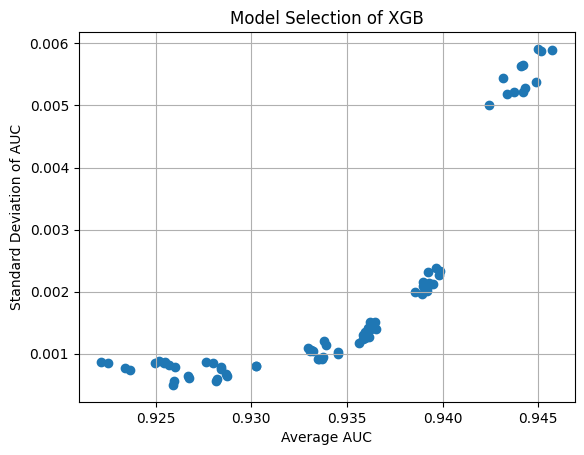

In [48]:
plt.scatter(grid_results["Average AUC"], grid_results["Std AUC"])
plt.grid(True)
plt.xlabel('Average AUC')
plt.ylabel('Standard Deviation of AUC')
plt.title('Model Selection of XGB')
plt.show()# slide 8a

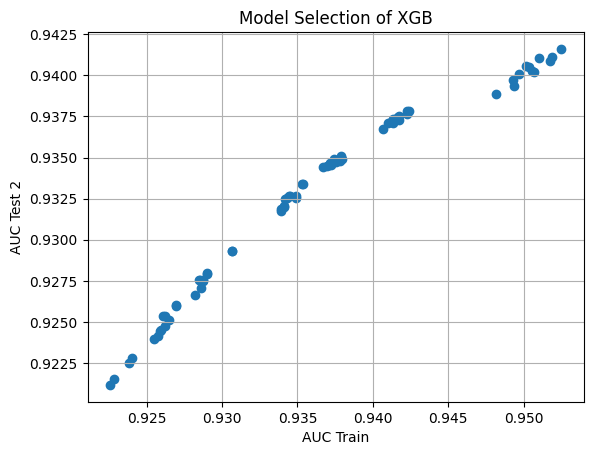

In [49]:
grid_results.sort_values(by=["Std AUC"])
x = grid_results.sort_values(by=["Std AUC"]).reset_index()
x[x["index"]==45]


plt.scatter(grid_results["AUC Train"], grid_results["AUC Test 2"])
plt.grid(True)
plt.xlabel('AUC Train')
plt.ylabel('AUC Test 2')
plt.title('Model Selection of XGB')
plt.show()# slide 8b

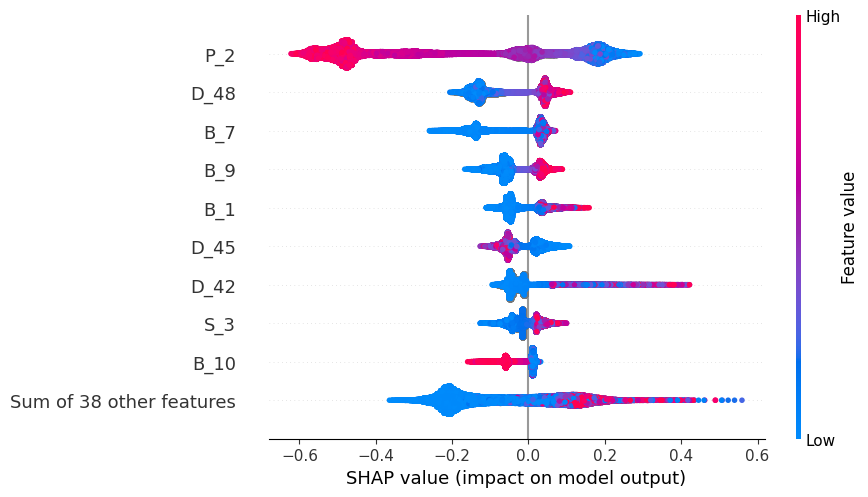

In [50]:
# Compute SHAP values from the best XGBoost model
explainer = shap.TreeExplainer(final_model)  # Ensure `best_xgb_model` is 
explanation = explainer(X_test2)
shap_values = explanation.values
shap.plots.beeswarm(explanation)

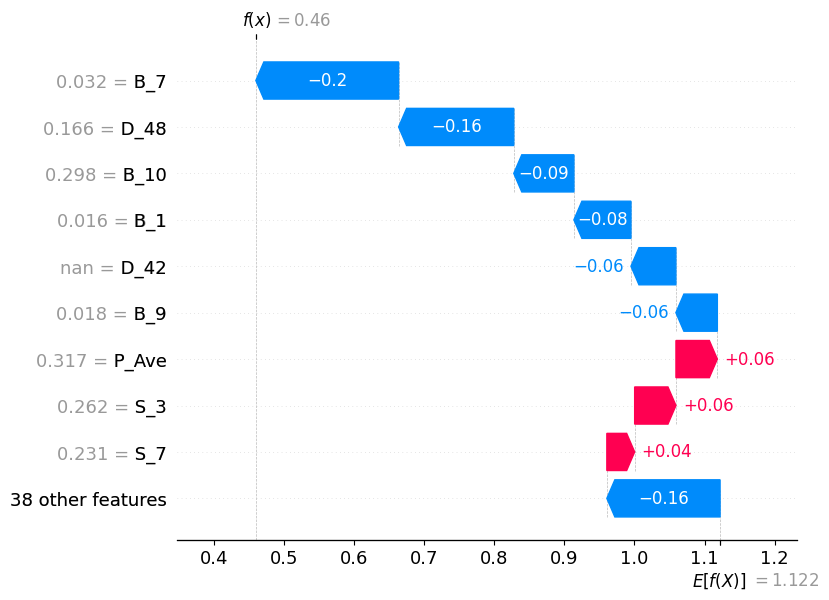

In [51]:
sample_index = 10  # Replace with the index of the sample you want to explain

# Create the Explanation object
explanation = shap.Explanation(values=shap_values[sample_index],
                                base_values=explainer.expected_value,
                                data=X_test2.iloc[sample_index],
                                feature_names=X_test2.columns.tolist())

# Generate the waterfall plot
shap.plots.waterfall(explanation)

In [52]:
shap_importance_1 = np.abs(shap_values).mean(axis=0)
shap_feature_importance_1 = pd.DataFrame({
    "Feature": X_test2.columns,
    "Mean SHAP Value": shap_importance_1
}).sort_values(by="Mean SHAP Value", ascending=False)
top_5_features = shap_feature_importance_1.head(5)["Feature"].tolist()

summary_stats = X_train[top_5_features].describe()

In [53]:
# Define the features of interest
top5_features = ["P_2", "D_48", "B_1", "D_44", "D_45"]

# Function to compute required statistics
def compute_feature_stats(df, feature_list):
    stats = df[feature_list].agg([
        "min",
        "max",
        lambda x: x.quantile(0.01),  # 1st percentile
        lambda x: x.quantile(0.05),  # 5th percentile
        "median",
        lambda x: x.quantile(0.95),  # 95th percentile
        lambda x: x.quantile(0.99),  # 99th percentile
        "mean"
    ]).T
    stats.columns = ["Min", "Max", "1%", "5%", "Median", "95%", "99%", "Mean"]

    # Compute % Missing values
    stats["% Missing"] = df[feature_list].isnull().mean() * 100
    
    return stats

# Compute stats for both test sets
stats = compute_feature_stats(X_train, top5_features)

stats


,Min,Max,1%,5%,Median,95%,99%,Mean,% Missing
P_2,-3.961235e-01,1.009999,0.005490,0.221433,0.693579,0.976794,1.005795,0.656154,0.848631
D_48,-9.608557e-03,3.297024,0.001329,0.013249,0.284007,0.941259,1.004738,0.381565,13.091087
B_1,-7.588799e+00,1.324052,0.000497,0.002155,0.031184,0.603631,1.006379,0.123941,0.000000
D_44,1.354806e-08,5.634724,0.000154,0.000761,0.007671,0.626064,1.006252,0.118832,4.951243
D_45,7.454545e-08,1.590110,0.004718,0.012733,0.181195,0.769511,1.002119,0.251656,0.035090


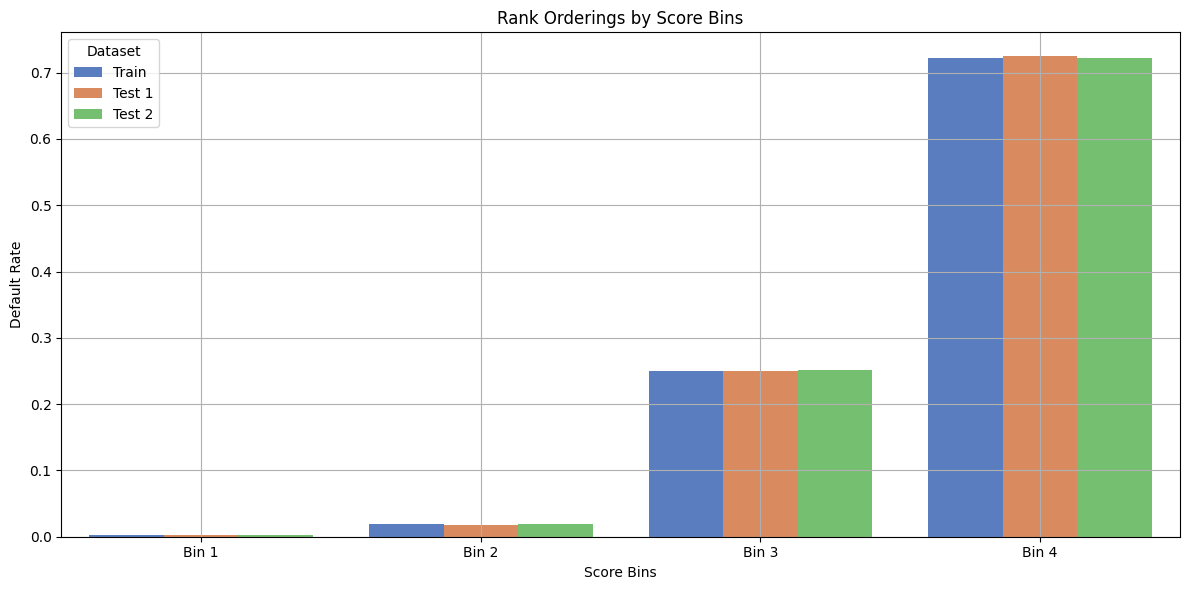

In [54]:
# Define score bins based on the train sample
train_scores = final_model.predict_proba(X_train)[:, 1]
bins = np.percentile(train_scores, [0, 25, 50, 75, 100])

# Apply the same thresholds to test samples
test1_scores = final_model.predict_proba(X_test1)[:, 1]
test2_scores = final_model.predict_proba(X_test2)[:, 1]

# Calculate default rates in each bin for each sample
def calculate_default_rate(scores, y):
    default_rates = []
    for i in range(len(bins) - 1):
        mask = (scores >= bins[i]) & (scores <= bins[i + 1])
        if np.sum(mask) > 0:
            default_rate = np.sum(y[mask]) / np.sum(mask)
            default_rates.append(default_rate)
        else:
            default_rates.append(0.0)
    return default_rates

default_rates_train = calculate_default_rate(train_scores, y_train)
default_rates_test1 = calculate_default_rate(test1_scores, y_test1)
default_rates_test2 = calculate_default_rate(test2_scores, y_test2)

df = pd.DataFrame({
    'Score Bins': [f"Bin {i+1}" for i in range(len(bins) - 1)],
    'Train': default_rates_train,
    'Test 1': default_rates_test1,
    'Test 2': default_rates_test2
})

# Melt DataFrame for better visualization
df_melted = df.melt(id_vars='Score Bins', var_name='Dataset', value_name='Default Rate')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.barplot(x='Score Bins', y='Default Rate', hue='Dataset', data=df_melted, palette='muted')
plt.xlabel('Score Bins')
plt.ylabel('Default Rate')
plt.title('Rank Orderings by Score Bins')
plt.legend(title='Dataset')
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
# Define score bins based on the train sample
train_scores = final_model.predict_proba(X_train)[:, 1]
bins = np.percentile(train_scores, [0, 25, 50, 75, 100])

# Apply the same thresholds to test samples
test1_scores = final_model.predict_proba(X_test1)[:, 1]
test2_scores = final_model.predict_proba(X_test2)[:, 1]

# Calculate default rates in each bin for each sample
def calculate_default_rate(scores, y):
    default_rates = []
    for i in range(len(bins) - 1):
        mask = (scores >= bins[i]) & (scores <= bins[i + 1])
        if np.sum(mask) > 0:
            default_rate = np.sum(y[mask]) / np.sum(mask)
            default_rates.append(default_rate)
        else:
            default_rates.append(0.0)
    return default_rates

default_rates_train = calculate_default_rate(train_scores, y_train)
default_rates_test1 = calculate_default_rate(test1_scores, y_test1)
default_rates_test2 = calculate_default_rate(test2_scores, y_test2)

# Create Plotly figure
fig = go.Figure()

# Add bar traces for each dataset
fig.add_trace(go.Bar(x=[f"Bin {i+1}" for i in range(len(bins) - 1)], y=default_rates_train, name='Train'))
fig.add_trace(go.Bar(x=[f"Bin {i+1}" for i in range(len(bins) - 1)], y=default_rates_test1, name='Test 1'))
fig.add_trace(go.Bar(x=[f"Bin {i+1}" for i in range(len(bins) - 1)], y=default_rates_test2, name='Test 2'))

# Add text annotations on top of each bar
annotation_offset = 0.05
for i, bin_label in enumerate([f"Bin {i+1}" for i in range(len(bins) - 1)]):
    fig.add_annotation(x=bin_label, y=default_rates_train[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_train[i]:.2f}", showarrow=False,
                       xshift=-50, yshift=10)
    fig.add_annotation(x=bin_label, y=default_rates_test1[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_test1[i]:.2f}", showarrow=False,
                       xshift=0, yshift=10)
    fig.add_annotation(x=bin_label, y=default_rates_test2[i], xanchor='center', yanchor='bottom',
                       text=f"{default_rates_test2[i]:.2f}", showarrow=False,
                       xshift=50, yshift=10)

# Update layout
fig.update_layout(barmode='group', xaxis_title='Score Bins', yaxis_title='Default Rate',
                  title='Rank Orderings by Score Bins', legend_title='Dataset')

# Show plot
fig.show()


# Neural Network

In [56]:
# Copy selected dataset
X_nn = train_data_selected.drop(['customer_ID', 'S_2', 'target'], axis=1).copy()

# Step 1: Handle Missing Values
X_nn.fillna(0, inplace=True)


In [58]:
# Step 2: Outlier Treatment (Cap & Floor at 1st and 99th percentile)
lower_bounds = X_nn.quantile(0.01)
upper_bounds = X_nn.quantile(0.99)

X_nn = X_nn.clip(lower=lower_bounds, upper=upper_bounds, axis=1)

In [59]:
# Step 3: Normalization using StandardScaler
scaler = StandardScaler()
X_nn_scaled = scaler.fit_transform(X_nn)

In [60]:
# Convert back to DataFrame
X_nn_scaled = pd.DataFrame(X_nn_scaled, columns=X_nn.columns)

# Save processed data for Neural Network training
X_nn_scaled.to_csv("processed_nn_data.csv", index=False)

In [61]:
# Load processed dataset
X_nn_scaled = pd.read_csv("processed_nn_data.csv")
y_train = train_data_selected['target']  # Target variable

# Split data into train and test
X_train, X_temp, y_train, y_temp = train_test_split(X_nn_scaled, y_train, test_size=0.3, random_state=42, stratify=y)
X_test1, X_test2, y_test1, y_test2 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [62]:
# Define hyperparameter grid
hidden_layers_options = [2, 4]
nodes_per_layer_options = [4, 6]
activation_options = ['relu', 'tanh']
dropout_options = [0, 0.5]
batch_size_options = [100, 10000]

In [63]:
%%time
# Initialize results dataframe
results = pd.DataFrame(columns=[
    "Hidden Layers", "# Nodes", "Activation", "Dropout", "Batch Size", "Train AUC", "Test AUC 1" , "Test AUC 2"
])

# Loop through different hidden layer settings
for hidden_layers in hidden_layers_options:
    for nodes_per_layer, activation, dropout, batch_size in itertools.product(
            nodes_per_layer_options, activation_options, dropout_options, batch_size_options):
        
        # Build the model
        model = Sequential()
        model.add(Dense(nodes_per_layer, activation=activation, input_shape=(X_train.shape[1],)))
        
        for _ in range(hidden_layers - 1):  # Add remaining hidden layers
            if dropout < 1.0:
                model.add(Dropout(dropout))
            model.add(Dense(nodes_per_layer, activation=activation))
        
        model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)
        
        # Compile model
        # Compile model with AUC tracking
        model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])


        # Train the model
        history = model.fit(X_train, y_train, epochs=20, batch_size=batch_size, verbose=0, validation_data=(X_test1, y_test1))

        # Ensure that the metric name is correctly retrieved
        train_auc = max(history.history.get('auc', [0]))  # Default to [0] to avoid errors
        test_auc1 = max(history.history.get('val_auc', [0]))  # AUC for Test Set 1
        test_auc2 = model.evaluate(X_test2, y_test2, verbose=0)[1]  # AUC for Test Set 2


        # Store results
        results.loc[len(results)] = [hidden_layers, nodes_per_layer, activation, dropout, batch_size, train_auc, test_auc1, test_auc2]

        # Save progress
        results.to_csv("nn_grid_search_results.csv", index=False)

print("Grid search complete! Results saved to 'nn_grid_search_results.csv'.")

Grid search complete! Results saved to 'nn_grid_search_results.csv'.
CPU times: user 1h 10min 50s, sys: 10min 16s, total: 1h 21min 6s
Wall time: 52min 4s


In [64]:
# Load the results from the grid search
results = pd.read_csv('nn_grid_search_results.csv')

In [65]:
results["Average AUC"] = results[["Train AUC","Test AUC 1","Test AUC 2"]].mean(axis=1)
results["Std AUC"] = results[["Train AUC","Test AUC 1","Test AUC 2"]].std(axis=1)

In [66]:
results["overfit_metric"] =(100*(1-results["Average AUC"]))**2 + ((results["Train AUC"]-results["Test AUC 1"])+
                                    (results["Train AUC"]-results["Test AUC 2"]))/results["Average AUC"]

In [67]:
results.sort_values(by=["overfit_metric"]).head()

,Hidden Layers,# Nodes,Activation,Dropout,Batch Size,Train AUC,Test AUC 1,Test AUC 2,Average AUC,Std AUC,overfit_metric
24,4,6,relu,0.0,100,0.934157,0.932019,0.935003,0.933726,0.001538,43.923349
8,2,6,relu,0.0,100,0.933856,0.931701,0.934921,0.933493,0.001641,44.233509
28,4,6,tanh,0.0,100,0.933782,0.931888,0.934448,0.933373,0.001328,44.393212
12,2,6,tanh,0.0,100,0.933558,0.931608,0.934284,0.933150,0.001384,44.690331
16,4,4,relu,0.0,100,0.933363,0.931566,0.934517,0.933149,0.001487,44.691861


In [68]:
results['Bias'] = abs(results['Train AUC'] - (results['Test AUC 1'] + results['Test AUC 2']) / 2)
results['Variance'] = abs(results['Test AUC 1'] - results['Test AUC 2'])

In [69]:
best_model = results.sort_values(by=['overfit_metric','Bias', 'Variance'])
best_model.head()

,Hidden Layers,# Nodes,Activation,Dropout,Batch Size,Train AUC,Test AUC 1,Test AUC 2,Average AUC,Std AUC,overfit_metric,Bias,Variance
24,4,6,relu,0.0,100,0.934157,0.932019,0.935003,0.933726,0.001538,43.923349,0.000645,0.002985
8,2,6,relu,0.0,100,0.933856,0.931701,0.934921,0.933493,0.001641,44.233509,0.000545,0.003221
28,4,6,tanh,0.0,100,0.933782,0.931888,0.934448,0.933373,0.001328,44.393212,0.000614,0.002560
12,2,6,tanh,0.0,100,0.933558,0.931608,0.934284,0.933150,0.001384,44.690331,0.000611,0.002676
16,4,4,relu,0.0,100,0.933363,0.931566,0.934517,0.933149,0.001487,44.691861,0.000321,0.002951


# Best Neural Network

In [70]:
best_hidden_layer = 4
best_nodes_per_layer = 6
best_activation= 'relu'
best_dropout = 0
best_batch_size = 100

final_model = Sequential()
final_model.add(Dense(best_nodes_per_layer, activation=best_activation, input_dim=X_train.shape[1]))

for _ in range(best_hidden_layer - 1):
    final_model.add(Dense(best_nodes_per_layer, activation=best_activation))
    if dropout > 0.0:
        final_model.add(Dropout(best_dropout))

final_model.add(Dense(1, activation='sigmoid'))

final_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])
        
final_model.fit(X_train, y_train, epochs=20, batch_size=best_batch_size, verbose=1)

Epoch 1/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - auc: 0.8809 - loss: 0.3827
Epoch 2/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - auc: 0.9322 - loss: 0.2817
Epoch 3/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - auc: 0.9329 - loss: 0.2800
Epoch 4/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - auc: 0.9329 - loss: 0.2797
Epoch 5/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - auc: 0.9337 - loss: 0.2780
Epoch 6/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - auc: 0.9336 - loss: 0.2786
Epoch 7/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - auc: 0.9341 - loss: 0.2769
Epoch 8/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - auc: 0.9332 - loss: 0.2793
Epoch 9/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - auc: 0.9331 - loss: 0.2793
Epoch 10/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - auc: 0.9340 - loss: 0.2781
Epoch 11/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - auc: 0.9335 - loss: 0.2787
Epoch 12/20
5415/5415 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - auc: 0.9341 - loss: 0.2773


In [71]:
# Save the final trained model
final_model.save("final_nn_model.h5")

# Evaluate the model on training and test sets (optional)
auc_train = roc_auc_score(y_train, final_model.predict(X_train, verbose=0))
auc_test1 = roc_auc_score(y_test1, final_model.predict(X_test1, verbose=0))
auc_test2 = roc_auc_score(y_test2, final_model.predict(X_test2, verbose=0))

In [72]:
print(auc_train)
print(auc_test1)
print(auc_test2)

0.9345781255724469
0.9321023605551595
0.9349971941137032


Choose Best model

In [73]:
# Load the saved Neural Network model
nn_model = tf.keras.models.load_model('final_nn_model.h5')

with open('final_xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)

In [74]:
# Predict with NN model
nn_train_preds = nn_model.predict(X_train)
nn_test1_preds = nn_model.predict(X_test1)
nn_test2_preds = nn_model.predict(X_test2)

16921/16921 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
3626/3626 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
3626/3626 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [75]:
# Predict using the trained XGBClassifier
xgb_train_preds = xgb_model.predict_proba(X_train)[:, 1] 
xgb_test1_preds = xgb_model.predict_proba(X_test1)[:, 1]
xgb_test2_preds = xgb_model.predict_proba(X_test2)[:, 1]

In [76]:
# Calculate AUC for NN model
nn_train_auc = roc_auc_score(y_train, nn_train_preds)
nn_test1_auc = roc_auc_score(y_test1, nn_test1_preds)
nn_test2_auc = roc_auc_score(y_test2, nn_test2_preds)

# Calculate AUC for XGBoost model
xgb_train_auc = roc_auc_score(y_train, xgb_train_preds)
xgb_test1_auc = roc_auc_score(y_test1, xgb_test1_preds)
xgb_test2_auc = roc_auc_score(y_test2, xgb_test2_preds)

In [77]:
# Display the results
print(f"Neural Network AUC:\nTrain AUC: {nn_train_auc}\nTest AUC 1: {nn_test1_auc}\nTest AUC 2: {nn_test2_auc}")
print(f"XGBoost AUC:\nTrain AUC: {xgb_train_auc}\nTest AUC 1: {xgb_test1_auc}\nTest AUC 2: {xgb_test2_auc}")

Neural Network AUC:
Train AUC: 0.9345781255724469
Test AUC 1: 0.9321023605551595
Test AUC 2: 0.9349971941137032
XGBoost AUC:
Train AUC: 0.9079745180384016
Test AUC 1: 0.9055092142434522
Test AUC 2: 0.9090844237403995


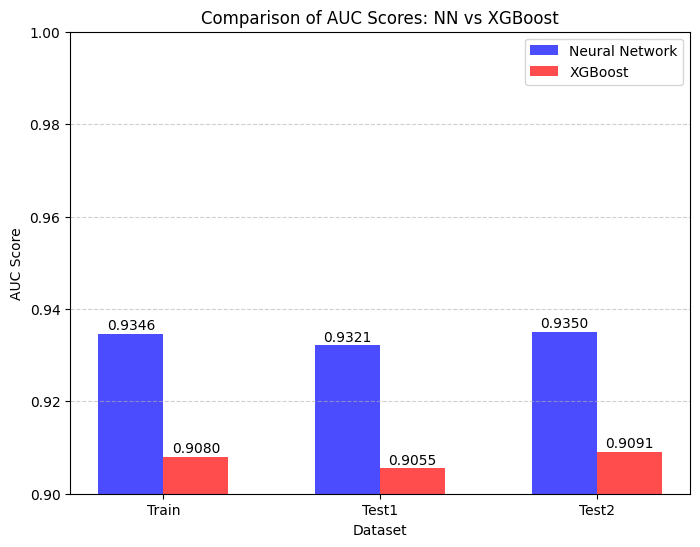

In [78]:
datasets = ['Train', 'Test1', 'Test2']
nn_auc = [nn_train_auc, nn_test1_auc, nn_test2_auc]
xgb_auc = [xgb_train_auc, xgb_test1_auc, xgb_test2_auc]

# Bar positions
x = np.arange(len(datasets))  # Label locations
width = 0.3  # Width of bars

# Plot bars
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, nn_auc, width, label='Neural Network', color='blue', alpha=0.7)
bars2 = ax.bar(x + width/2, xgb_auc, width, label='XGBoost', color='red', alpha=0.7)

# Labels & Title
ax.set_xlabel("Dataset")
ax.set_ylabel("AUC Score")
ax.set_title("Comparison of AUC Scores: NN vs XGBoost")
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.set_ylim(0.9, 1.0)  # Adjust based on AUC values
ax.legend()

# Show values on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
